<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# Machine Learning Foundation

## Course 5, Part a: Gradient Descent DEMO


## Overview
In this notebook, we will solve a simple linear regression problem by gradient descent.  
We will see the effect of the learning rate on the trajectory in parameter space.
We will show how Stochastic Gradient Descent (SGD) differs from the standard version, and the effect of "shuffling" your data during SGD.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Generate Data from a known distribution
Below we will generate data a known distribution.  
Specifically, the true model is:

$Y = b + \theta_1 X_1 + \theta_2 X_2 + \epsilon$  

Where:-  
$Y$ = independent variable  
$b$ = intercept / bias term  
$\theta_1, \theta_2$ = coefficients/ weights  
$X_1, X_2$ = independent variables/ features  
$\epsilon$ = error term/ residual  

---
    
$X_1$ and $X_2$ have a uniform distribution on the interval $[0,10]$, while `const` is a vector of ones (representing the intercept term).

We set actual values for $b$ ,$\theta_1$, and $\theta_2$

Here $b=1.5$, $\theta_1=2$, and $\theta_2=5$

We then generate a vector of $y$-values according to the model and put the predictors together in a "feature matrix" `x_mat`


In [2]:
# This ensures we get the same data if all of the other parameters remain fixed
np.random.seed(1234)

n_obs = 100 # number of observations
x1 = np.random.uniform(0, 10, n_obs) # (lower bound, upper bound, n_rand values)
x2 = np.random.uniform(0, 10, n_obs)
const = np.ones(n_obs)

# Draw random sample from a normal (Gaussian) distribution
# 'eps' represents Epsilon
eps = np.random.normal(loc=0, scale=5, size=n_obs) # (mean, std, n)

b, theta1, theta2 = 1.5, 2, 5

y = b + theta1 * x1 + theta2 * x2 + eps # 𝑌 = 𝑏 + 𝜃1𝑋1 + 𝜃2𝑋2 + 𝜖
x_mat = np.array([const, x1, x2]).T
print(x_mat[:10])

[[1.         1.9151945  7.67116628]
 [1.         6.22108771 7.08115362]
 [1.         4.37727739 7.96867184]
 [1.         7.85358584 5.57760828]
 [1.         7.79975808 9.65836532]
 [1.         2.72592605 1.471569  ]
 [1.         2.76464255 0.29647001]
 [1.         8.01872178 5.93893493]
 [1.         9.58139354 1.14065699]
 [1.         8.75932635 9.5080985 ]]


In [3]:
print(y[:10])

[46.83009956 50.28041526 54.86030569 50.03590101 65.02830119 11.55668248
  3.82087206 41.03676037 27.06448838 65.44405029]


In [4]:
x_mat.shape, y.shape

((100, 3), (100,))

## Get the "Right" answer directly
In the below cells we solve for the optimal set of coefficients.  Note that even though the true model is given by:

$b=1.5$, $\theta_1=2$, and $\theta_2=5$

The maximum likelihood (least-squares) estimate from a finite data set may be slightly different.


## Exercise:
Solve the problem two ways:
1. By using the scikit-learn LinearRegression model
2. Using matrix algebra directly via the formula $\theta = (X^T X)^{-1}X^Ty$

Note: The scikit-learn solver may give a warning message, this can be ignored.


In [5]:
# Solve directly using sklearn
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression(fit_intercept=False)
# "fit_intercept=False" means The intercept 'b' is forced to 0.
# The model will only learn the slopes (w), so the regression line must pass through the origin (0,0).
lr_model.fit(x_mat, y)
lr_model.coef_
# 'w1'=1.49, 'w2'=1.99, 'w3' = 5.01

array([1.40046175, 1.9675416 , 5.11563148])

In [6]:
# Predicted values
y_pred = lr_model.predict(x_mat)
y_pred[:10]

array([44.41154637, 49.86528301, 50.77772565, 45.38570713, 66.15544795,
       14.29183936,  8.35664227, 47.5590329 , 26.0874329 , 67.27472876])

**Check function line**

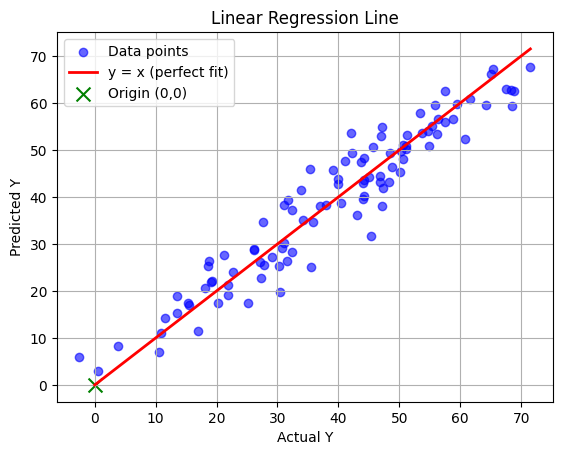

In [7]:
# Scatter plot of Actual vs Predicted
plt.scatter(y, y_pred, color='blue', alpha=0.6, label="Data points")

# Regression line (ideal line through origin)
max_val = max(max(y), max(y_pred))
plt.plot([0, max_val], [0, max_val],
         color="red",
         linewidth=2,
         label="y = x (perfect fit)")

# Check explicitly if passes through (0,0)
plt.scatter(0, 0, color="green", s=100, marker="x", label="Origin (0,0)")

plt.xlabel("Actual Y")
plt.ylabel("Predicted Y")
plt.title("Linear Regression Line")
plt.legend()
plt.grid(True)
plt.show()

**Equation:**  
$\text{Linear Regression Coefficients} = \hat \beta = (X^T.X)^{-1}.X^T y$

In [8]:
# Solve using matrix calculation
np.linalg.inv(np.dot(x_mat.T, x_mat)).dot(x_mat.T).dot(y)

array([1.40046175, 1.9675416 , 5.11563148])

## Solving by Gradient Descent


For most numerical problems, we don't / can't know the underlying analytical solution. This is because we only arrive at analytical solutions by solving the equations mathematically, with pen and paper. That is more often than not just impossible. Fortunately, we have a way of converging to an approximate solution, by using **Gradient Descent**.


We will explore this very useful method because Neural Networks, along with many other complicated algorithms, are trained using Gradient Descent.  Seeing how gradient descent works on a simple example will build intuition and help us understand some of the nuances around setting the learning rate and other parameters.  We will also explore Stochastic Gradient Descent and compare its behavior to the standard approach.


## Exercise

The next several cells have code to perform (full-batch) gradient descent.  We have omitted some parameters for you to fill in.

1. Pick a learning rate, and a number of iterations, run the code, and then plot the trajectory of your gradient descent.
1. Find examples where the learning rate is too high, too low, and "just right".
1. Look at plots of loss function under these conditions.



$\displaystyle y_{pred} = \theta^T.x$  
Here, the model is $\theta$.  

---
**Sum of Squared Error (SSE)**    
**Definition**: measures how far your predictions are from the actual values.  
- Large value means `poor fit`.
- Small value means `good fit`.

$\displaystyle L(\theta) = \sum_{j=1}^n{(y^j-\hat y^j)^2}$  
Where,   
$y$ = true value  
$\hat y$ = predicted value  
$()^2$ = makes all error positive, penalizes all large errors more  
$\sum_{j=1}^{n}$ = gives the total error across all 100 samples.  

---  

Gradient descent updating parameters:  
$\theta = \theta + \eta . \nabla_0 . SSE$  
Where,
$\eta$ = learning rate  
$\nabla_0 SSE$ = gradient of SSE w.r.t $\theta$

In [ ]:
# Initialization
learning_rate = 1e-3  # 1e-3 = 0.001
num_iter = 10000
theta_initial = np.array([3,3,3])

def gradient_descent(learning_rate, num_iter, theta_initial):
    theta = theta_initial
    theta_path = np.zeros((num_iter + 1, 3)) # shape: (10001, 3)
    theta_path[0,:] = theta_initial # initialize the array with [3 | 3 | 3]
    loss_vec = np.zeros(num_iter) # shape: (10000,)

    # Main Gradient Descent loop (for a fixed number of iterations)
    for i in range(num_iter):
        y_pred = np.dot(theta.T, x_mat.T) # shape: ((1, 3) x (3, 100)) = (100,)
        loss_vec[i] = np.sum((y - y_pred)**2) # Sum of Squared Error (SSE)
        # Sum up the gradients across all observations and divide by n_obs
        grad_vec = (y - y_pred).dot(x_mat) / n_obs
        theta = theta + learning_rate * grad_vec # update theta weight
        theta_path[i+1, :] = theta # stored updated theta into theta_path
    return theta_path, loss_vec

In [ ]:
true_coef = [b, theta1, theta2]
gdtype = "Gradient Descent"

def plot_ij(theta_path, i, j, ax):
    # Plot for "true_coef" = "[b, theta1, theta2]"
    ax.plot(true_coef[i], true_coef[j], marker='p', # 'p' for pentagon marker
            markersize=15, label='true coef', color='#778899')
    # Plot for updated theta values
    ax.plot(theta_path[:, i],theta_path[:, j],
                color='k', linestyle='--', marker='*',
                markersize=9,
                markevery=50) # use '*' only 50th data points
    # Plot start point at (3, 3)
    ax.plot(theta_path[0, i], theta_path[0, j], marker='d', # 'd' for diamond marker
            markersize=15, label='start', color='green')
    # Plot end point at (1,87, 1.92)
    ax.plot(theta_path[-1, i], theta_path[-1, j], marker='o',
            markersize=15, label='end', color='#F08080')
    ax.set(xlabel=f"$\\theta_{0}$", ylabel=f"$\\theta_{1}$")
    ax.axis('equal') #
    ax.grid(True) # add grid lines
    ax.legend(loc='best') # the legend at best position

def plot_all(theta_path, loss_vec, learning_rate, num_iter, theta_initial):
    fig = plt.figure(figsize=(16,16))
    title = '{gdtype} in the 3d parameter space - Learning rate is {lr} // {iters} iters // starting point {initial}'
    title = title.format(gdtype=gdtype, lr=learning_rate,
                        iters=num_iter, initial=theta_initial)
    fig.suptitle(title, fontsize=20)
    # Add subplot with 'b' and 'theta1'
    ax = fig.add_subplot(2, 2, 1)
    plot_ij(theta_path, 0, 1, ax)
    # Add subplot with 'b' and 'theta2'
    ax = fig.add_subplot(2, 2, 2)
    plot_ij(theta_path, 0, 2, ax)
    # Add subplot with 'theta1' and 'theta2'
    ax = fig.add_subplot(2, 2, 3)
    plot_ij(theta_path, 1, 2, ax)
    # Add subplot
    ax = fig.add_subplot(2, 2, 4)
    ax.plot(loss_vec)
    ax.set(xlabel='iterations', ylabel='squared loss')
    ax.grid(True)


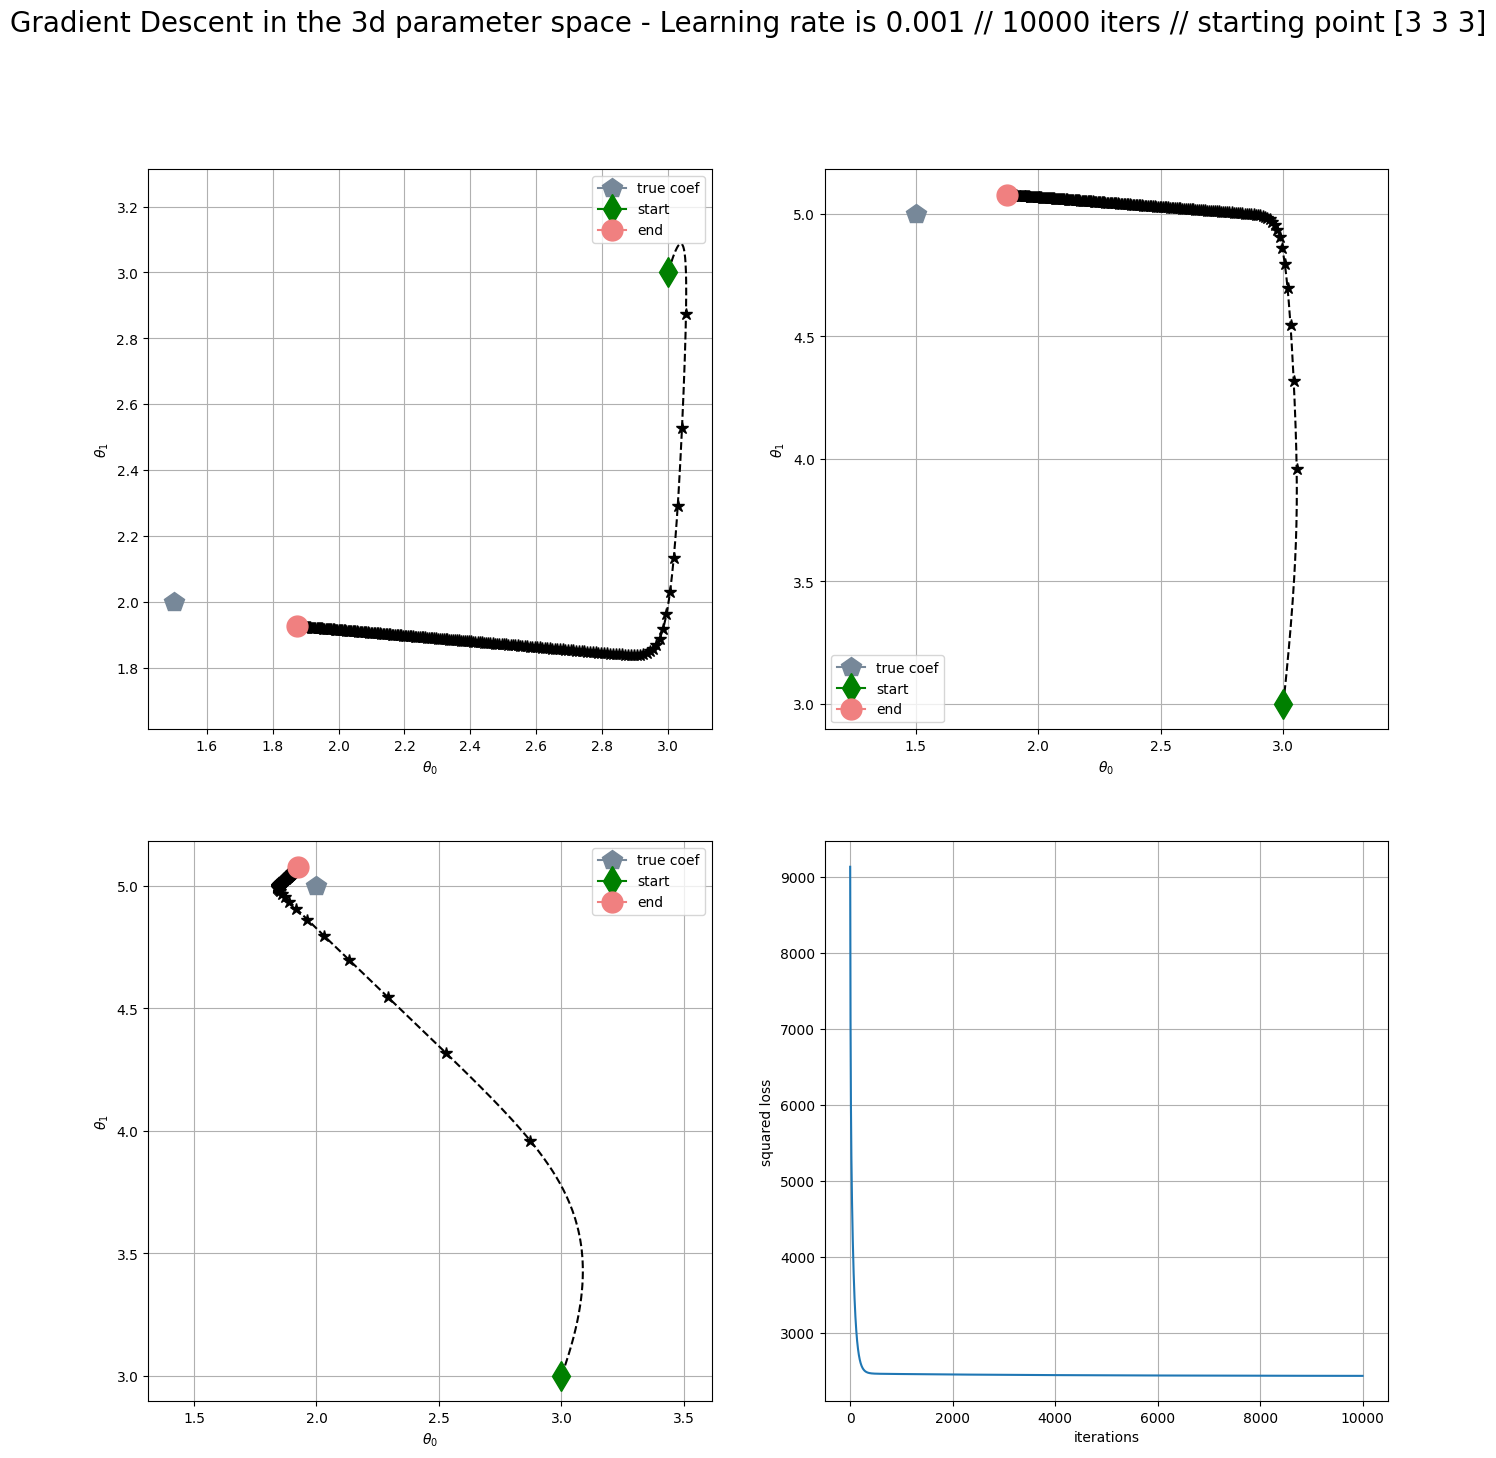

In [ ]:
theta_path, loss_vec = gradient_descent(learning_rate, num_iter, theta_initial)
plot_all(theta_path, loss_vec, learning_rate, num_iter, theta_initial)

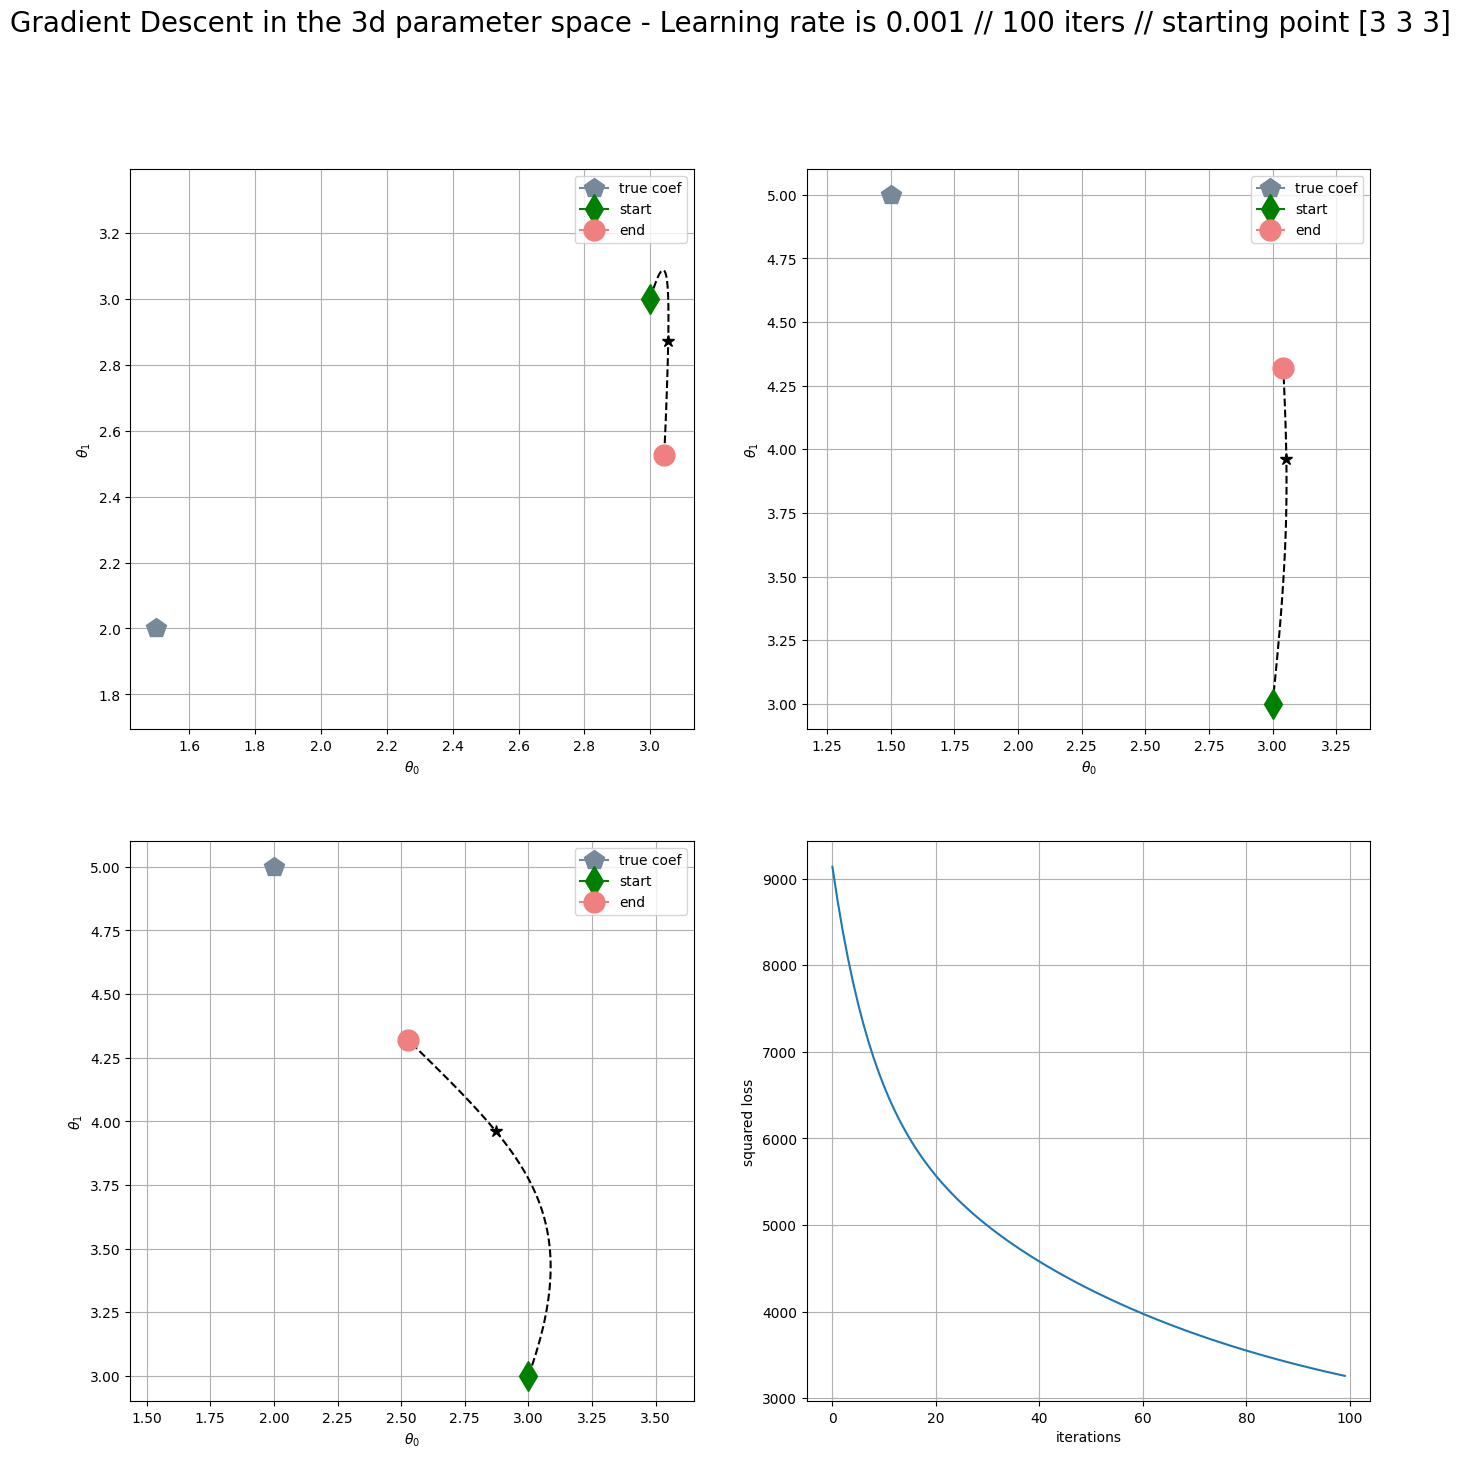

In [ ]:
# Changed num_iter = 100
learning_rate = 1e-3  # 1e-3 = 0.001
num_iter = 100
theta_path, loss_vec = gradient_descent(learning_rate, num_iter, theta_initial)
plot_all(theta_path, loss_vec, learning_rate, num_iter, theta_initial)

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipython-input-2168687844.py:15: RuntimeWarning: overflow encountered in square
  loss_vec[i] = np.sum((y - y_pred)**2) # Sum of Squared Error (SSE)
/tmp/ipython-input-2168687844.py:18: RuntimeWarning: invalid value encountered in add
  theta = theta + learning_rate * grad_vec # update theta weight


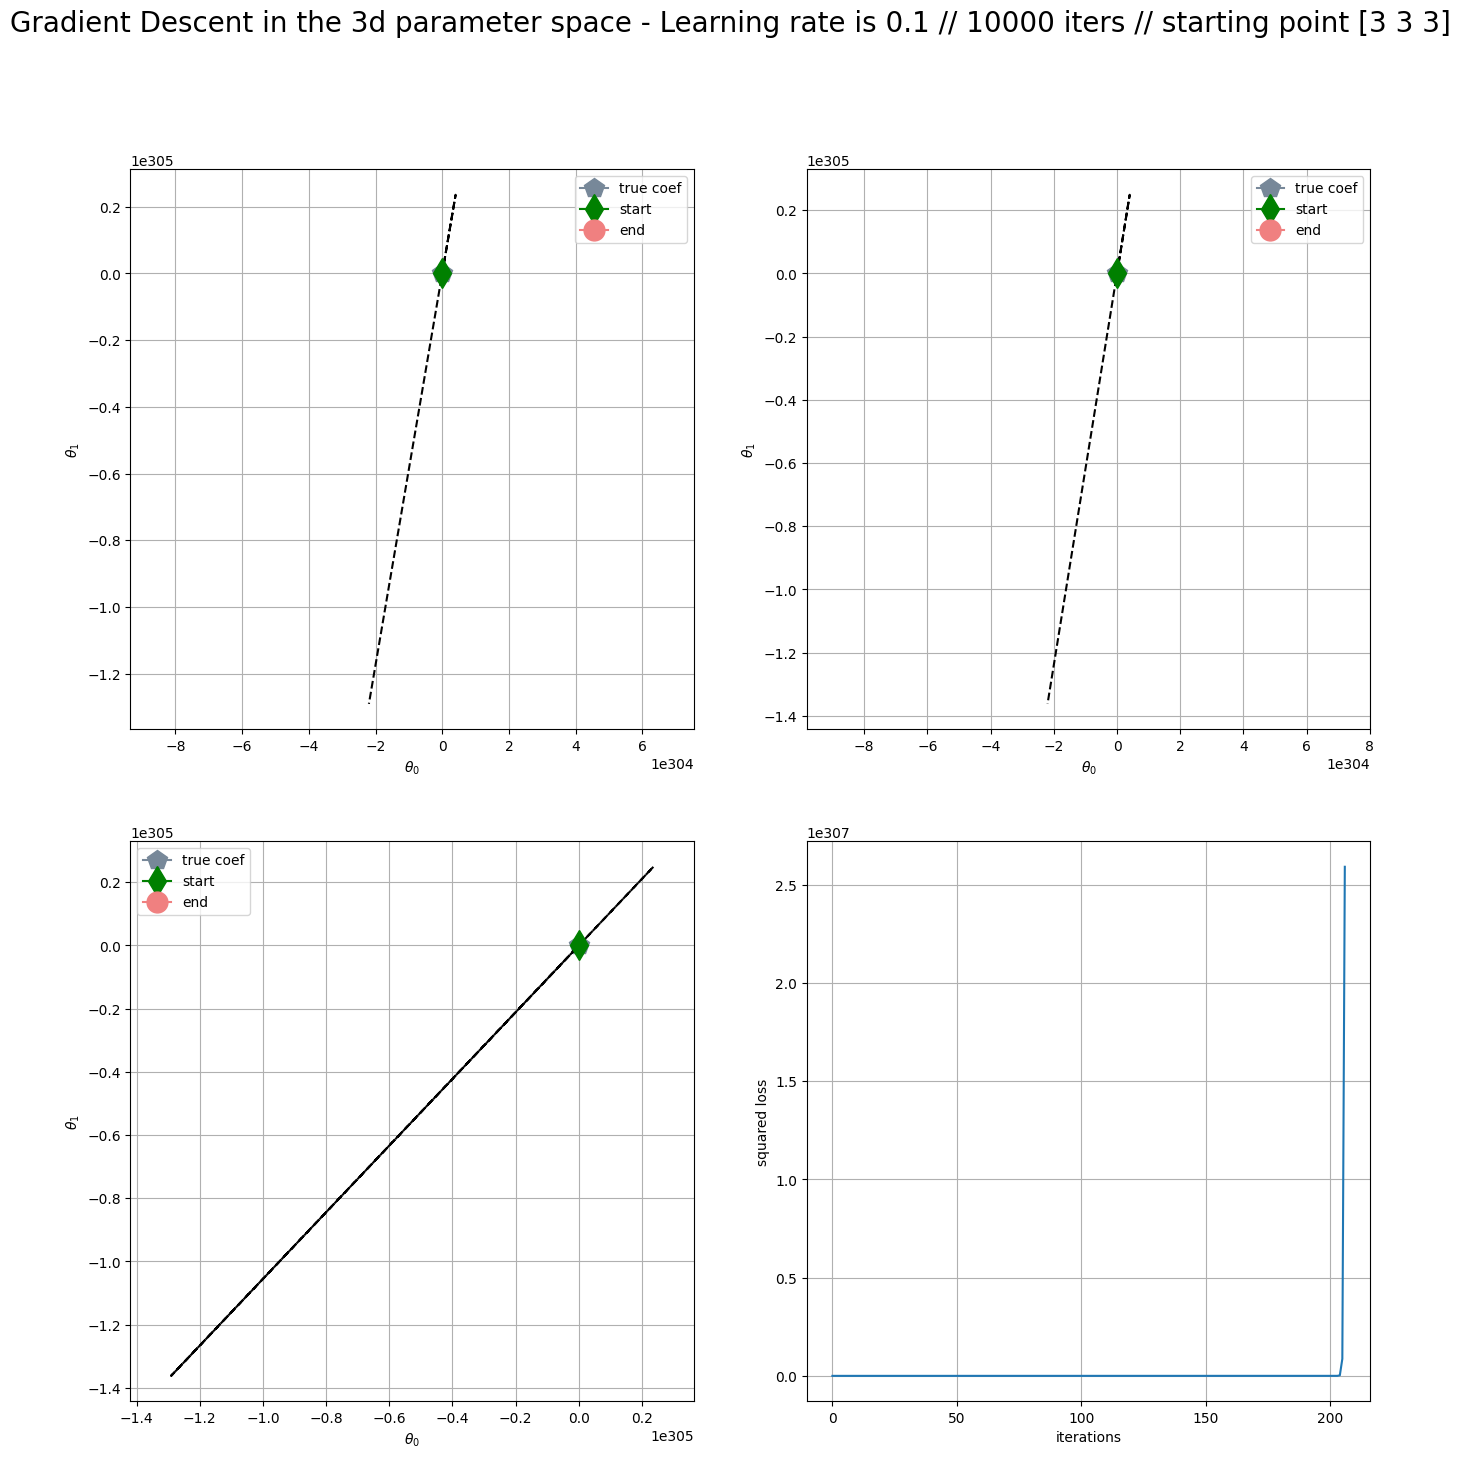

In [ ]:
# Increased learning_rate = 1e-1
learning_rate = 1e-1  # 1e-3 = 0.1
num_iter = 10000
theta_path, loss_vec = gradient_descent(learning_rate, num_iter, theta_initial)
plot_all(theta_path, loss_vec, learning_rate, num_iter, theta_initial)

## Stochastic Gradient Descent
Rather than average the gradients across the whole dataset before taking a step, we will now take a step for every datapoint.  Each step will be somewhat of an "overreaction" but they should average out.  


## Exercise
The below code runs Stochastic Gradient descent, but runs through the data in the same order every time.  

1. Run the code and plot the graphs.  What do you notice?
2. Modify the code so that it randomly re-orders the data.  How do the sample trajectories compare?


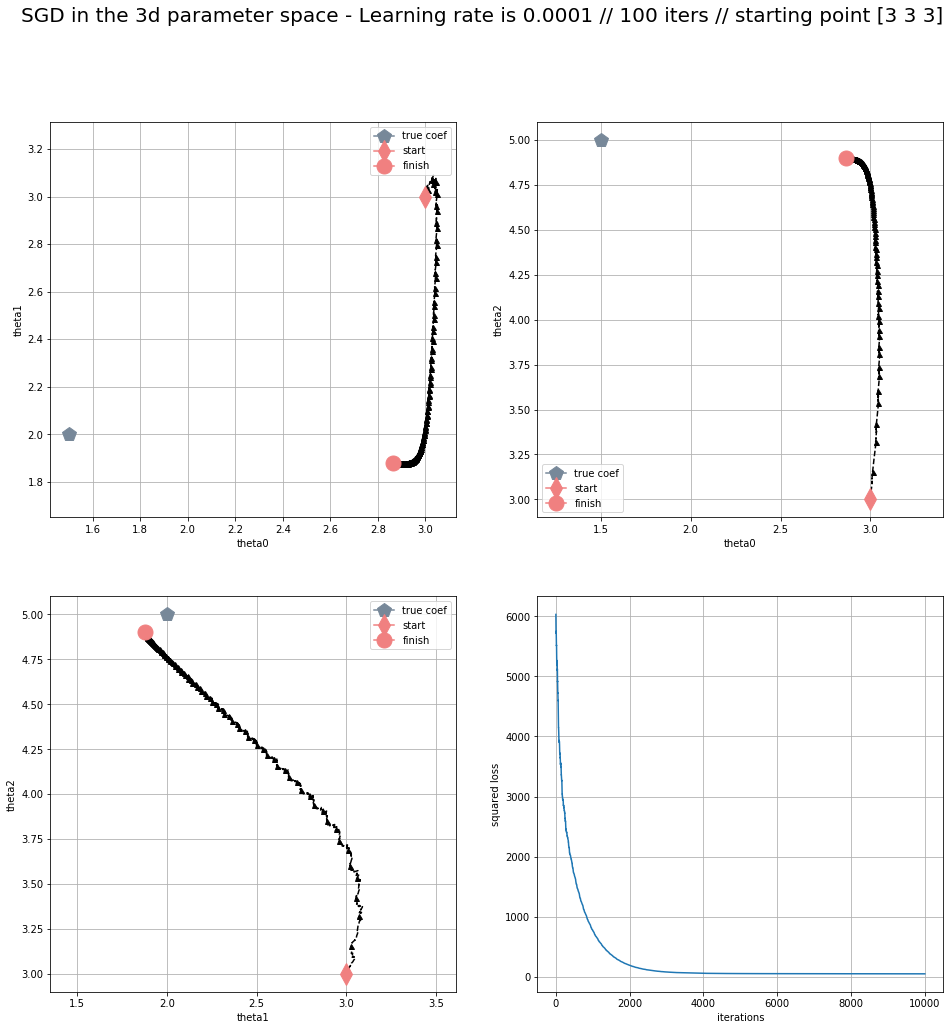

In [ ]:
def stochastic_gradient_descent(learning_rate, num_iter, theta_initial):

    ## Initialization steps
    theta = theta_initial
    # below are different in STOCHASTIC gradient descent
    theta_path = np.zeros(((num_iter*num_obs)+1,3))
    theta_path[0,:] = theta_initial
    loss_vec = np.zeros(num_iter*num_obs)

    ## Main SGD loop
    count = 0
    for i in range(num_iter):
        for j in range(num_obs):
            count+=1
            y_pred = np.dot(theta.T,x_mat.T)
            loss_vec[count-1] = np.sum((y-y_pred)**2)
            grad_vec = (y[j]-y_pred[j])*(x_mat[j,:])
            theta = theta + learning_rate*grad_vec
            theta_path[count,:]=theta
    return theta_path, loss_vec

## Parameters to play with
learning_rate = 1e-4
num_iter = 100
theta_initial = np.array([3, 3, 3])


theta_path, loss_vec = stochastic_gradient_descent(learning_rate,
                                                   num_iter,
                                                   theta_initial)
plot_all(theta_path, loss_vec, learning_rate,
         num_iter, theta_initial, 'SGD')

Play with the parameters below and observe the trajectory it results in


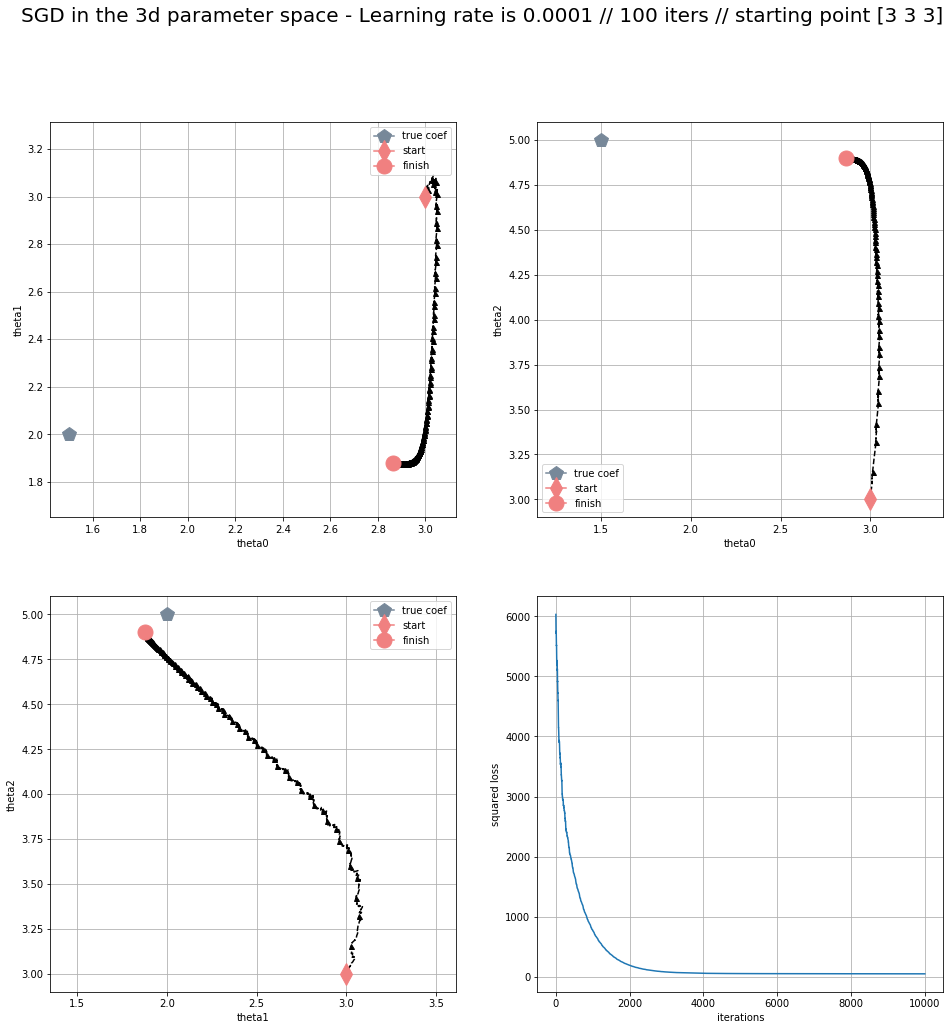

In [ ]:
## Parameters to play with
learning_rate = 1e-4
num_iter = 100
theta_initial = np.array([3,3,3])


theta_path, loss_vec = stochastic_gradient_descent(learning_rate,
                                                   num_iter,
                                                   theta_initial)
plot_all(theta_path, loss_vec, learning_rate, num_iter,
         theta_initial, 'SGD')

---
### Machine Learning Foundation (C) 2020 IBM Corporation
